<a href="https://colab.research.google.com/github/Keachebet/Tomato-Leaf-Disease-Classificatio/blob/main/Tomato_Plant_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [69]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

In [ ]:
from google.colab import drive

In [ ]:
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [ ]:
len(dataset)

141

In [ ]:
141*32

4512

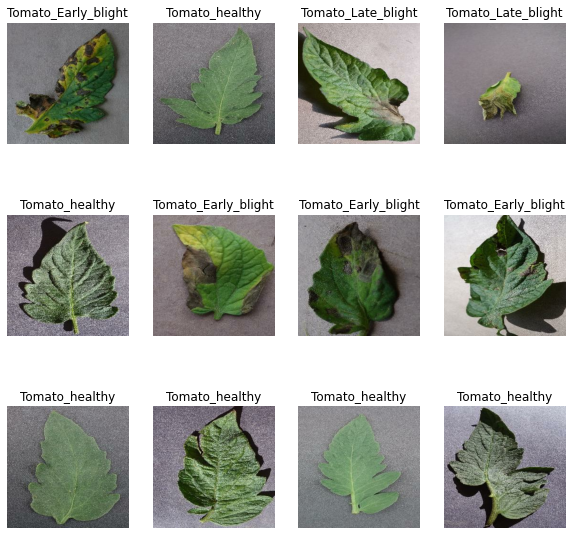

In [38]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  #print(image_batch.shape)
  #print(label_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [40]:
len(dataset)

141

In [42]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [43]:
train_ds = dataset.take(112)
len(train_ds)

112

In [44]:
test_ds = dataset.skip(112)
len(test_ds)

29

In [45]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [46]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [47]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [49]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [50]:
len(train_ds)

112

In [51]:
len(val_ds)

14

In [52]:
len(test_ds)

15

In [54]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [56]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [61]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [64]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [66]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [67]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
112/112 [==============================] - 405s 4s/step - loss: 0.3337 - accuracy: 0.8561 - val_loss: 0.5115 - val_accuracy: 0.8371
Epoch 2/10
112/112 [==============================] - 403s 4s/step - loss: 0.3633 - accuracy: 0.8494 - val_loss: 0.6621 - val_accuracy: 0.7969
Epoch 3/10
112/112 [==============================] - 403s 4s/step - loss: 0.3031 - accuracy: 0.8723 - val_loss: 0.2395 - val_accuracy: 0.9129
Epoch 4/10
112/112 [==============================] - 401s 4s/step - loss: 0.2939 - accuracy: 0.8749 - val_loss: 0.4003 - val_accuracy: 0.8616
Epoch 5/10
112/112 [==============================] - 402s 4s/step - loss: 0.2469 - accuracy: 0.8987 - val_loss: 0.2408 - val_accuracy: 0.9174
Epoch 6/10
112/112 [==============================] - 400s 4s/step - loss: 0.2835 - accuracy: 0.8953 - val_loss: 0.3465 - val_accuracy: 0.8750
Epoch 7/10
112/112 [==============================] - 403s 4s/step - loss: 0.2223 - accuracy: 0.9031 - val_loss: 0.2443 - val_accuracy: 0.8973

In [71]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 30s 1s/step - loss: 0.1600 - accuracy: 0.9333


In [72]:
scores

[0.16001324355602264, 0.9333333373069763]

In [73]:
history

In [74]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 112}

In [75]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

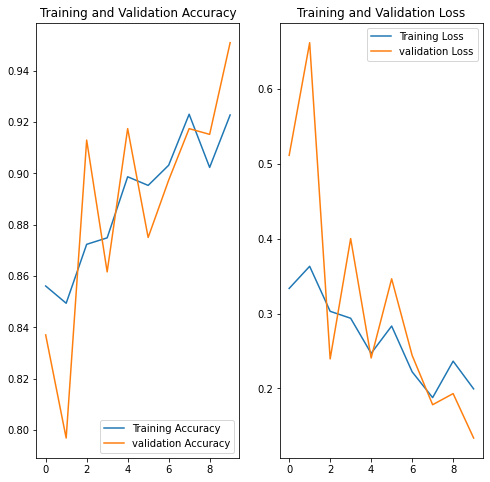

In [80]:
#plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [94]:
np.argmax([0.04968536, 0.89451694, 0.05579771])

1

first image to predict
actual label: Tomato_Early_blight
1/1 [==============================] - 1s 943ms/step
predicted label: Tomato_Early_blight


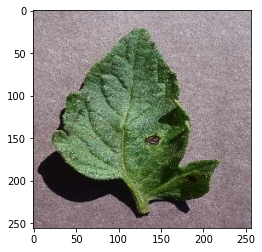

In [97]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])
  
  batch_prediction = model.predict(images_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [98]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #create a batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)
  return predicted_class, confidence


1/1 [==============================] - 0s 47ms/step


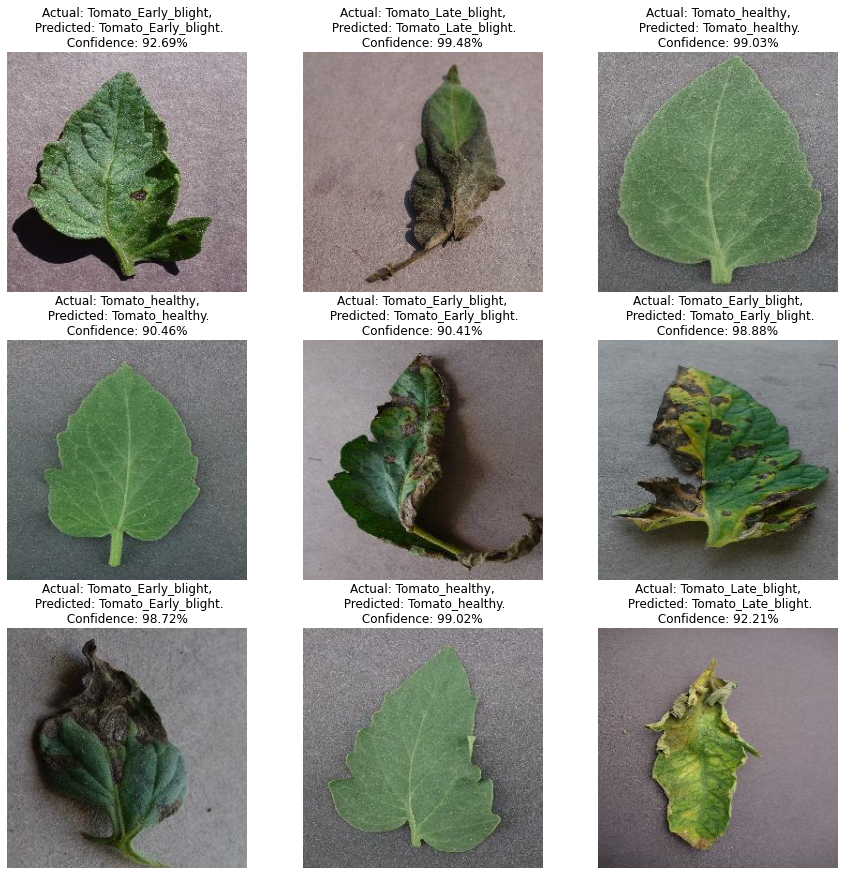

In [103]:
plt.figure(figsize= (15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}% ")

    plt.axis("off")

In [108]:
#To keep a running count import os (incremental model)
#convert string to integer using list comprehension
model_version = max([int(i) for i in os.listdir("/content/models")+ [0]])+1
model.save(f"/content/models/{model_version}")